In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import jax.numpy as np
from jax import grad, jit, vmap
from jax.experimental.ode import odeint
from functools import partial

Populating the interactive namespace from numpy and matplotlib


In [2]:
# First, let's define some analytic dndz
def smail_nz(z, a=2.0, b=1.5,z0=1.):
    return z**a * np.exp(-(z / z0)**b)

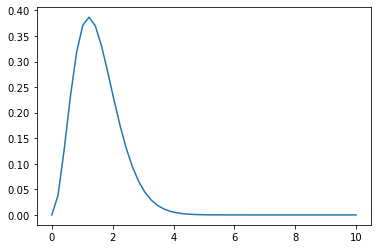

In [50]:
z = np.linspace(0,10)
plot(z, smail_nz(z))

In [51]:
from jax_cosmo import Planck15, background
import jax_cosmo.ops as ops
from jax_cosmo.utils import a2z, z2a
from jax_cosmo.power import linear_matter_power

In [138]:
cosmo = Planck15()

a = np.linspace(0.1,1.)
z = a2z(a)
r = background.radial_comoving_distance(cosmo, a)

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype <class 'jax.num

In [141]:
background.H(cosmo, 1.)

DeviceArray(100., dtype=float32)

In [142]:
r = background.radial_comoving_distance(cosmo, a)
import jax_cosmo.constants as const

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [144]:
def lensing_kernel(cosmo, chi, pz=smail_nz):
    """
    Compute lensing efficiency integrated over redshift distribution
    
    W(chi)
    
    This only works in flat.... but ok...
    """
    # Get intergration bounds
    z_min = a2z(background.a_of_chi(cosmo, chi))[0]
    
    def integrand(y, z, chi, cosmo):
        chi_prime = background.radial_comoving_distance(cosmo, z2a(z)) 
        return pz(z) * (chi_prime - chi)/(chi_prime + 1e-5)
    y = odeint(integrand, 0., np.linspace(z_min, 10.0, 10), chi, cosmo)
    return  y[-1]

In [145]:
w = vmap(lensing_kernel, (None, 0))

In [149]:
# Now we can compute the angular_cl
def angular_cl(cosmo, ell):
    
    atab = np.linspace(0.1,1.)
    r = background.radial_comoving_distance(cosmo, atab)
    # Tabulate the lensing kernle
    wtab = w(cosmo, r)
    
    def integrand(y, a, cosmo, ell, atab, wtab):
        print("Bonjour")
        # Step 1
        chi = background.radial_comoving_distance(cosmo, a)

        # Step 2: get the powers pectrum for this combination 
        k = (ell+0.5)/chi
        pk = linear_matter_power(cosmo, k, a)
        
        kernel = ops.interp(np.atleast_1d(a), atab, wtab)[0]
        
        # Step 3: return the integrand
        return  (1 + a2z(a))**2 * pk * kernel**2 * background.dchioverda(cosmo, a)
    
    y = odeint(integrand, 0., np.linspace(0.1, 1.,10), cosmo, ell, atab, wtab)
    
    factor = (3.0 * const.H0**2 * cosmo.Omega_m / (2.0 * const.c**2))**2 
    factor *= ((ell-1)*(ell)*(ell+1)*(ell+2))/(ell+0.5)**2
        
    return factor * y[-1]

In [150]:
toto = jit(vmap(angular_cl, (None, 0)))

In [151]:
toto(cosmo, np.linspace(50,100,10))

Bonjour
Bonjour
Bonjour


DeviceArray([1.8465667e-05, 2.0451847e-05, 2.2342565e-05, 2.4134468e-05,
             2.5836547e-05, 2.7446620e-05, 2.8962340e-05, 3.0383606e-05,
             3.1719905e-05, 3.2960976e-05], dtype=float32)

In [152]:
%timeit toto(cosmo, np.linspace(50,100,20))

Bonjour
Bonjour
Bonjour
The slowest run took 46.82 times longer than the fastest. This could mean that an intermediate result is being cached.
17.5 ms ± 25.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


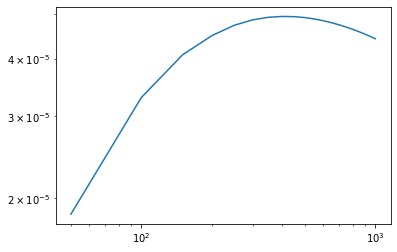

In [153]:
loglog(np.linspace(50,1000,20), toto(cosmo, np.linspace(50,1000,20)))

In [111]:
def integrand(y, z, chi, cosmo):
    chi_prime = background.radial_comoving_distance(cosmo, z2a(z)) 
    return smail_nz(z) * np.clip(chi_prime - chi, 0.)/(chi_prime + 1e-5)

In [112]:
toto = integrand(0, a2z(a), 1000., cosmo)

/home/francois/.local/lib/python3.8/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


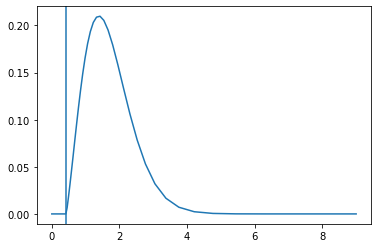

In [113]:
plot((a2z(a)), toto)
axvline(a2z(background.a_of_chi(cosmo, 1000.)))

In [94]:
simps(toto, a2z(a))

-0.6333545759921554

In [96]:
lensing_kernel(cosmo, 100., smail_nz)

DeviceArray(0.63342035, dtype=float32)

In [78]:
toto

DeviceArray([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 6.3555206e-10, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
             4.6707910e-08, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00, 4.8608642e-09, 0.0000000e+00,
             0.0000000e+00, 0.0000000e+00], dtype=float32)

In [79]:
from scipy.integrate import simps

In [ ]:
simps()

In [55]:
lensing_kernel(cosmo, 1000., smail_nz)

DeviceArray(0.34341523, dtype=float32)

In [56]:
background.a_of_chi(cosmo, r)

DeviceArray([0.09999999, 0.11822045, 0.13653392, 0.15496156, 0.17346936,
             0.19162914, 0.21020412, 0.22857139, 0.2469388 , 0.2653061 ,
             0.28367347, 0.30204085, 0.32040817, 0.3382085 , 0.35683936,
             0.3755102 , 0.3938776 , 0.41181028, 0.43061212, 0.4489795 ,
             0.46718436, 0.4857143 , 0.50375617, 0.522449  , 0.5404532 ,
             0.5591836 , 0.5772827 , 0.5959183 , 0.6142509 , 0.63169897,
             0.6510204 , 0.668823  , 0.6877551 , 0.7060914 , 0.72357047,
             0.74285716, 0.7610005 , 0.7785037 , 0.7979592 , 0.81609035,
             0.83362275, 0.8530612 , 0.87135583, 0.8889285 , 0.9071332 ,
             0.92627466, 0.94489795, 0.9632653 , 0.9816327 , 1.        ],            dtype=float32)

In [57]:
background.radial_comoving_distance(cosmo, 0.1)

DeviceArray([4987.9434], dtype=float32)

In [97]:
fun = vmap(lensing_kernel, (None, 0, None))

In [98]:
w = fun(cosmo, r, smail_nz)

In [99]:
w

DeviceArray([2.1559104e-13, 2.1835783e-10, 1.8847006e-08, 4.7136038e-07,
             5.1320435e-06, 3.1416203e-05, 1.3006596e-04, 4.0562867e-04,
             1.0239813e-03, 2.1973380e-03, 4.1601793e-03, 7.1401619e-03,
             1.1332970e-02, 1.6897311e-02, 2.3953239e-02, 3.2561384e-02,
             4.2547636e-02, 5.4056622e-02, 6.7021191e-02, 8.1061445e-02,
             9.6482418e-02, 1.1272513e-01, 1.3004361e-01, 1.4803581e-01,
             1.6681086e-01, 1.8602343e-01, 2.0588282e-01, 2.2585386e-01,
             2.4653414e-01, 2.6686540e-01, 2.8778559e-01, 3.0856496e-01,
             3.2939583e-01, 3.5058889e-01, 3.7113017e-01, 3.9196685e-01,
             4.1280460e-01, 4.3312094e-01, 4.5363000e-01, 4.7403178e-01,
             4.9389482e-01, 5.1386631e-01, 5.3384745e-01, 5.5311489e-01,
             5.7244092e-01, 5.9181428e-01, 6.1069697e-01, 6.2934178e-01,
             6.4800036e-01, 6.6666669e-01], dtype=float32)

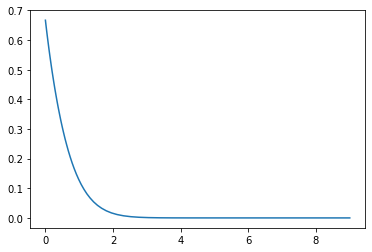

In [100]:
plot(z, w)

In [25]:
atab = np.logspace(-3., 0.)
chitab = background.radial_comoving_distance(cosmo, atab)

def lensing_kernel(cosmo, a, pz, atab, chitab):
    """
    Compute lensing efficiency integrated over redshift distribution
    
    W(chi)
    
    This only works in flat.... but ok...
    """
    # Precompute comoving distance values
    ztab = a2z(atab)
    chi = ops.interp(np.atleast_1d(a), atab, chitab)[0]
    
    def integrand(y, z, chi, ztab, chitab):
        chi_prime = ops.interp(np.atleast_1d(z), ztab, chitab)[0]
        return pz(z) * (chi_prime - chi)/chi_prime
    
    y = odeint(integrand, 0., np.linspace(a2z(a), 10.0, 10), chi, ztab, chitab)
    return y[-1]

In [29]:
w = vmap(lensing_kernel, (None, 0, None, None, None))

In [37]:
w(cosmo, np.linspace(0.1, 1.), smail_nz, atab, chitab)

DeviceArray([2.41236122e-13, 2.30938296e-10, 1.97929229e-08,
             4.89916204e-07, 5.38875565e-06, 3.22368651e-05,
             1.32603716e-04, 4.19580640e-04, 1.03131111e-03,
             2.24366249e-03, 4.18714760e-03, 7.30331615e-03,
             1.14285704e-02, 1.71002615e-02, 2.42234431e-02,
             3.26842070e-02, 4.30323854e-02, 5.45101427e-02,
             6.72440454e-02, 8.16913545e-02, 9.72460136e-02,
             1.13202035e-01, 1.30502135e-01, 1.49110720e-01,
             1.67768493e-01, 1.86616272e-01, 2.06353679e-01,
             2.26962447e-01, 2.47827679e-01, 2.67773479e-01,
             2.88251758e-01, 3.09228063e-01, 3.30687970e-01,
             3.52015108e-01, 3.72149467e-01, 3.92548829e-01,
             4.13192660e-01, 4.34056878e-01, 4.55131620e-01,
             4.75346059e-01, 4.94805425e-01, 5.14380276e-01,
             5.34034133e-01, 5.53771138e-01, 5.73563695e-01,
             5.93406796e-01, 6.13291383e-01, 6.33194029e-01,
             6.53100491e

In [45]:
# Now we can compute the angular_cl
def angular_cl(cosmo, ell, nz, atab, chitab):
    
    # Tabulate the lensing kernle
    wtab = w(cosmo, np.linspace(0.1, 1.), nz, atab, chitab)
    
    def integrand(y, a, cosmo, ell, atab, chitab, wtab):
        print("Bonjour")
        # Step 1: we compute a_ell, chi_ell for this k
        chi = ops.interp(np.atleast_1d(a), atab, chitab)[0]
                        
        # Step 2: get the powers pectrum for this combination 
        pk = linear_matter_power(cosmo, (ell+0.5)/chi, a)
        
        w = ops.interp(np.atleast_1d(a), np.linspace(0.1, 1.), wtab)[0]
        
        # Step 3: return the integrand
        return  (1 + a2z(a))**2 * pk * w**2 * background.dchioverda(cosmo, a)
    
    y = odeint(integrand, 0., np.linspace(0.1, 1.,10), cosmo, ell, atab, chitab, wtab)
    return y[-1]

In [46]:
angular_cl(cosmo, 30, smail_nz, atab, chitab)

Bonjour
Bonjour
Bonjour


DeviceArray(4266006.5, dtype=float32)

In [47]:
fun = vmap(partial(angular_cl, nz=smail_nz, atab=atab, chitab=chitab), (None, 0))

In [48]:
r = fun(cosmo, np.linspace(20,100,10))

Bonjour
Bonjour
Bonjour


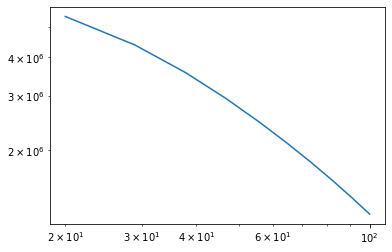

In [51]:
loglog(np.linspace(20,100,10), r)

In [112]:
# Now we can compute the angular_cl
def angular_cl(cosmo, ell, nz):
    # Step 1:
    # Prepare some interpolation arrays for the distance
    atab = np.logspace(-3, 0., 100)
    chitab = background.radial_comoving_distance(cosmo, atab)
    
    def integrand(y, k, cosmo, ell, atab, chitab):
        # Step 1: we compute a_ell, chi_ell for this k
        chi_ell = np.atleast_1d((ell + 0.5)/k)
        a_ell = ops.interp(chi_ell, chitab, atab)[0]
        
        # Step 2: get the powerspectrum for this combination 
        pk = linear_matter_power(cosmo, k, a_ell)
        
        # Step 3: return the integrand
        return pk * lensing_kernel(cosmo, chi_ell, nz)**2
    
    y = odeint(integrand, 0., np.linspace(0.1, 1.), cosmo, ell, atab, chitab)
    return y[-1]

In [113]:
angular_cl(cosmo, 30., smail_nz)

DeviceArray(-59391.477, dtype=float32)

In [103]:
ell=100

In [104]:
atab = np.logspace(-3, 0., 100)
chitab = background.radial_comoving_distance(cosmo, atab)
nz=smail_nz

In [105]:
def integrand(y, k, cosmo, ell, atab, chitab):
    # Step 1: we compute a_ell, chi_ell for this k
    chi_ell = np.atleast_1d((ell + 0.5)/k)
    a_ell = ops.interp(chi_ell, chitab, atab)[0]

    # Step 2: get the powerspectrum for this combination 
    pk = linear_matter_power(cosmo, k, a_ell)

    # Step 3: return the integrand
    return pk * lensing_kernel(cosmo, chi_ell, nz)**2

In [106]:
integrand(0, 0.1, cosmo, ell, atab, chitab)

DeviceArray(449.5506, dtype=float32)

In [107]:
k=0.1
# Step 1: we compute a_ell, chi_ell for this k
chi_ell = np.atleast_1d((ell + 0.5)/k)
a_ell = ops.interp(chi_ell, chitab, atab)[0]

In [108]:
a_ell, chi_ell

(DeviceArray(0.69844633, dtype=float32), DeviceArray([1005.], dtype=float32))

In [109]:
pk = linear_matter_power(cosmo, k, a_ell)

In [110]:
pk

DeviceArray(3839.5442, dtype=float32)

In [111]:
lensing_kernel(cosmo, chi_ell, nz)

DeviceArray(0.34217593, dtype=float32)

In [10]:
from functools import partial

In [11]:
fun = jit(vmap(partial(angular_cl, nz=smail_nz), (None, 0))) 

In [13]:
res = fun(cosmo, np.linspace(10.,100.,10))

/home/francois/.local/lib/python3.7/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/francois/.local/lib/python3.7/site-packages/jax/lax/lax.py:5190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [ ]:
plot(np.linspace(10,100,10), res)

In [ ]:
plot(np.linspace(10,100), res)

In [27]:
res

DeviceArray([0.0000000e+00, 8.0321872e+07, 1.6131539e+09, 8.7849585e+09,
             2.8782578e+10, 7.1793271e+10, 1.5100461e+11, 2.8260457e+11,
             4.8578186e+11, 7.8272535e+11, 1.1986237e+12, 1.7616672e+12,
             2.5030458e+12, 3.4569498e+12, 4.6605680e+12, 6.1540957e+12,
             7.9807224e+12, 1.0186640e+13, 1.2821042e+13, 1.5936122e+13,
             1.9587070e+13, 2.3832073e+13, 2.8732339e+13, 3.4352059e+13,
             4.0758426e+13, 4.8021635e+13, 5.6214881e+13, 6.5414361e+13,
             7.5699268e+13, 8.7151807e+13, 9.9857168e+13, 1.1390354e+14,
             1.2938215e+14, 1.4638717e+14, 1.6501580e+14, 1.8536827e+14,
             2.0754773e+14, 2.3166044e+14, 2.5781558e+14, 2.8612525e+14,
             3.1670488e+14, 3.4967221e+14, 3.8514908e+14, 4.2325916e+14,
             4.6413010e+14, 5.0789166e+14, 5.5467744e+14, 6.0462328e+14,
             6.5786873e+14, 7.1455566e+14], dtype=float32)

In [ ]:
(cosmo, 100, smail_nz)

In [145]:
ell = 500.
k = 1.
nz = smail_nz
atab = np.logspace(-4, 0., 100)
chitab = background.radial_comoving_distance(cosmo, atab)

In [146]:
# Step 1: we compute a_ell, chi_ell for this k
chi_ell = np.atleast_1d((ell + 0.5)/k)
a_ell = ops.interp(chi_ell, chitab, atab)[0]
print(chi_ell, a_ell)

[500.5] 0.84104544


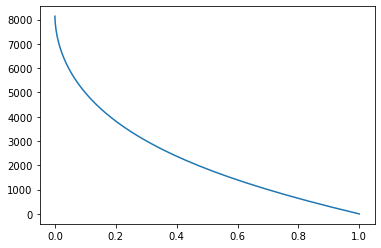

In [147]:
plot(atab, chitab)

In [148]:
# Step 2: get the powerspectrum for this combination 
pk = linear_matter_power(cosmo, k, a_ell)

In [149]:
pk

DeviceArray(54.83165, dtype=float32)

In [150]:
pk * lensing_kernel(cosmo, a_ell, chi_ell, nz)**2

DeviceArray([6.988691], dtype=float32)

In [151]:
a2z(a_ell)

DeviceArray(0.18899643, dtype=float32)

In [155]:
def integrand(y, k, cosmo):
    # Step 1: we compute a_ell, chi_ell for this k
    chi_ell = np.atleast_1d((ell + 0.5)/k)
    a_ell = ops.interp(chi_ell, chitab, atab)[0]

    # Step 2: get the powerspectrum for this combination 
    pk = linear_matter_power(cosmo, k, a_ell)

    # Step 3: return the integrand
    return pk * lensing_kernel(cosmo, a_ell, chi_ell, nz)**2

In [156]:
integrand(0., k, cosmo)

DeviceArray([6.988691], dtype=float32)

In [157]:
y = odeint(integrand, 0., np.array([0.1, 10]), cosmo)

UnexpectedTracerError: Encountered an unexpected tracer. Perhaps this tracer escaped through global state from a previously traced function.
The functions being transformed should not save traced values to global state.
Details: Can't lift level Traced<ShapedArray(float32[10,1]):JaxprTrace(level=2/2)> to JaxprTrace(level=-3/2).

In [87]:
ell = 1000.
k = 0.01

In [88]:
# Step 1: we compute a_ell, chi_ell for this k
chi_ell = np.atleast_1d((ell + 0.5)/k)
a_ell = ops.interp(chi_ell, chitab, atab)[0]
print(chi_ell, a_ell)

[100050.] -6.097719


In [85]:
background.radial_comoving_distance(cosmo, 0.002)

DeviceArray(7761.8022, dtype=float32)

In [ ]:
    # Step 1: we compute a_ell, chi_ell for this k
    chi_ell = np.atleast_1d((ell + 0.5)/k)
    a_ell = ops.interp(chi_ell, chitab, atab)[0]

    # Step 2: get the powerspectrum for this combination 
    pk = linear_matter_power(cosmo, k, a_ell)

    # Step 3: return the integrand
    return pk * lensing_kernel(cosmo, a_ell, chi_ell, nz)**2

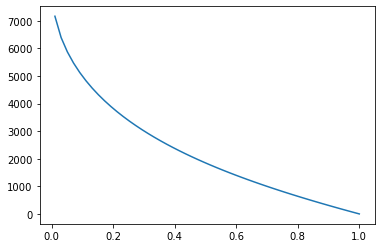

In [10]:
plot(a,r)

In [16]:
rs  = np.linspace(100, 6000, 100)

In [17]:
a_s = ops.interp(rs,r,a)

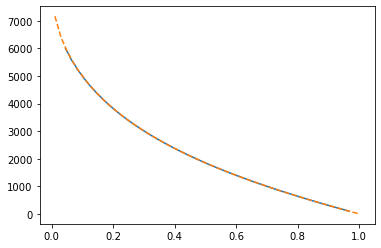

In [19]:
plot(a_s, rs)
plot(a,r, '--')

In [26]:
from jax_cosmo.utils import a2z

In [42]:
a2 = background.a_of_chi(cosmo, r, steps=100)

(-0.01, 0.01)

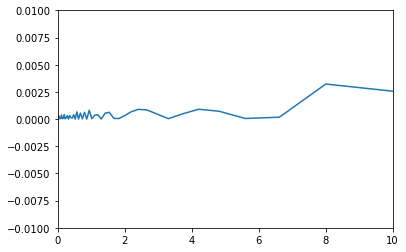

In [43]:
plot(a2z(a), a2z(a2)-a2z(a),)
xlim(0,10)
ylim(-0.01, 0.01)

(-0.01, 0.01)

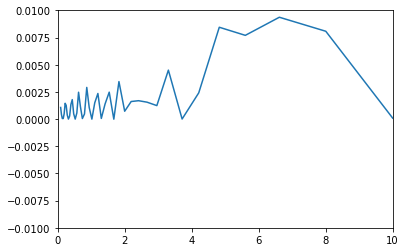

In [41]:
plot(a2z(a), a2z(a2)-a2z(a),)
xlim(0,10)
ylim(-0.01, 0.01)

(0, 10)

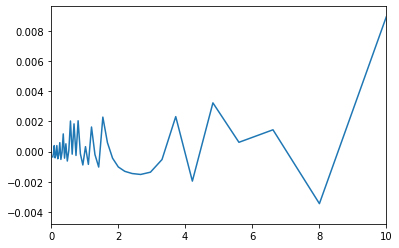

In [36]:
plot(a2z(a), a2z(a2)-a2z(a),)
xlim(0,10)

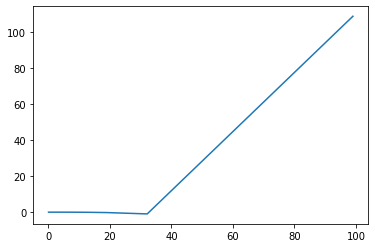

In [29]:
plot(a2z(a), a2z(a2)-a2z(a))

In [22]:
r

DeviceArray([7169.3545  , 6395.16    , 5879.07    , 5471.508   ,
             5128.464   , 4829.54    , 4563.2427  , 4322.3115  ,
             4101.8057  , 3898.1785  , 3708.7795  , 3531.5657  ,
             3364.9226  , 3207.537   , 3058.356   , 2916.4854  ,
             2781.1763  , 2651.79    , 2527.7612  , 2408.6401  ,
             2294.001   , 2183.4785  , 2076.7485  , 1973.523   ,
             1873.5454  , 1776.5854  , 1682.4341  , 1590.9023  ,
             1501.8188  , 1415.0259  , 1330.3799  , 1247.7495  ,
             1167.0239  , 1088.0742  , 1010.8032  ,  935.11475 ,
              860.91797 ,  788.1294  ,  716.66943 ,  646.47314 ,
              577.459   ,  509.56738 ,  442.73584 ,  376.90674 ,
              312.02393 ,  248.03418 ,  184.8877  ,  122.51709 ,
               60.907227,    0.      ], dtype=float32)